# Testing A2C, PPO, and Random Actions

### Imports

In [11]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback

In [12]:
from trade_flow.environments import metatrader

### Create Env

In [13]:
# env_name = 'forex-hedge-v0'
# env_name = 'stocks-hedge-v0'
env_name = 'crypto-hedge-v0'
# env_name = 'mixed-hedge-v0'

# env_name = 'forex-unhedge-v0'
# env_name = 'stocks-unhedge-v0'
# env_name = 'crypto-unhedge-v0'
# env_name = 'mixed-unhedge-v0'

env = gym.make(env_name)

/home/fortesenselabs/anaconda3/envs/algo_trading/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 6)
  logger.warn(
/home/fortesenselabs/anaconda3/envs/algo_trading/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float64. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/home/fortesenselabs/anaconda3/envs/algo_trading/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:34: UserWarning: WARN: It seems a Box observation space is an image but the lower and upper bounds are not [0, 255]. A

### Define Functions

In [14]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()

In [15]:
# TRAINING + TEST
def train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps=10_000):
    """ if model=None then execute 'Random actions' """

    # reproduce training and test
    print('-' * 80)
    obs = env.reset(seed=seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    vec_env = None

    if model is not None:
        print(f'model {type(model)}')
        print(f'policy {type(model.policy)}')
        # print(f'model.learn(): {total_learning_timesteps} timesteps ...')

        # custom callback for 'progress_bar'
        model.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))
        # model.learn(total_timesteps=total_learning_timesteps, progress_bar=True)
        # ImportError: You must install tqdm and rich in order to use the progress bar callback. 
        # It is included if you install stable-baselines with the extra packages: `pip install stable-baselines3[extra]`

        vec_env = model.get_env()
        obs = vec_env.reset()
    else:
        print ("RANDOM actions")

    reward_over_episodes = []

    tbar = tqdm(range(total_num_episodes))

    for episode in tbar:
        
        if vec_env: 
            obs = vec_env.reset()
        else:
            obs, info = env.reset()

        total_reward = 0
        done = False

        while not done:
            if model is not None:
                action, _states = model.predict(obs)
                obs, reward, done, info = vec_env.step(action)
            else: # random
                action = env.action_space.sample()
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

            total_reward += reward
            if done:
                break

        reward_over_episodes.append(total_reward)

        if episode % 10 == 0:
            avg_reward = np.mean(reward_over_episodes)
            tbar.set_description(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}')
            tbar.update()

    tbar.close()
    avg_reward = np.mean(reward_over_episodes)

    return reward_over_episodes

### Train + Test Env

In [16]:
seed = 2024  # random seed
total_num_episodes = 50

print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}


env_name                 : crypto-hedge-v0
seed                     : 2024


In [17]:
# Random actions
model = None 
total_learning_timesteps = 0
rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
min, avg, max = print_stats(rewards)
class_name = f'Random actions'
label = f'Avg. {avg:>7.2f} : {class_name}'
plot_data['rnd_rewards'] = rewards
plot_settings['rnd_rewards'] = {'label': label}

--------------------------------------------------------------------------------
RANDOM actions


Episode: 40, Avg. Reward: -9999.814: 100%|██████████| 50/50 [01:09<00:00,  1.38s/it]

Min. Reward          : -10000.000
Avg. Reward          :  -9999.826
Max. Reward          :  -9998.400


In [18]:
# Agents
learning_timesteps_list_in_K = [25]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
model_class_list = [A2C, PPO]

for timesteps in learning_timesteps_list_in_K:
    total_learning_timesteps = timesteps * 1000
    step_key = f'{timesteps}K'

    for model_class in model_class_list:
        policy_dict = model_class.policy_aliases
        # https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
        policy = policy_dict.get('MultiInputPolicy')

        try:
            model = model_class(policy, env, verbose=0)
            class_name = type(model).__qualname__
            plot_key = f'{class_name}_rewards_'+step_key
            rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
            min, avg, max, = print_stats(rewards)
            label = f'Avg. {avg:>7.2f} : {class_name} - {step_key}'
            plot_data[plot_key] = rewards
            plot_settings[plot_key] = {'label': label}     

        except Exception as e:
            print(f"ERROR: {str(e)}")
            continue

--------------------------------------------------------------------------------
model <class 'stable_baselines3.a2c.a2c.A2C'>
policy <class 'stable_baselines3.common.policies.MultiInputActorCriticPolicy'>


model.learn():   0%|          | 0/25000 [00:00<?, ?it/s]

Episode: 40, Avg. Reward: 176.217: 100%|██████████| 50/50 [01:56<00:00,  2.32s/it]


Min. Reward          :  -3126.357
Avg. Reward          :    130.411
Max. Reward          :   1834.719
--------------------------------------------------------------------------------
model <class 'stable_baselines3.ppo.ppo.PPO'>
policy <class 'stable_baselines3.common.policies.MultiInputActorCriticPolicy'>


model.learn(): 26600it [01:49, 243.13it/s]                           
Episode: 40, Avg. Reward: -9938.245: 100%|██████████| 50/50 [03:41<00:00,  4.42s/it]

Min. Reward          : -10000.006
Avg. Reward          :  -9949.361
Max. Reward          :  -7468.124
ERROR: The algorithm only supports (<class 'gymnasium.spaces.discrete.Discrete'>,) as action spaces but Box(-100.0, 100.0, (12,), float64) was provided


### Plot Results

In [19]:
data = pd.DataFrame(plot_data)

data

,x,rnd_rewards,A2C_rewards_25K,PPO_rewards_25K
0,1,-9999.758073,[0.0],[-9999.997]
1,2,-10000.000000,[0.0],[-10000.001]
2,3,-10000.000000,[-195.44843],[-10000.0]
3,4,-9998.473790,[0.0],[-9999.999]
4,5,-10000.000000,[0.0],[-10000.0]
5,6,-10000.000000,[1074.5945],[-10000.0]
6,7,-10000.000000,[0.0],[-9999.993]
7,8,-10000.000000,[0.0],[-9999.995]
8,9,-10000.000000,[0.0],[-10000.002]
9,10,-10000.000000,[0.0],[-9999.996]


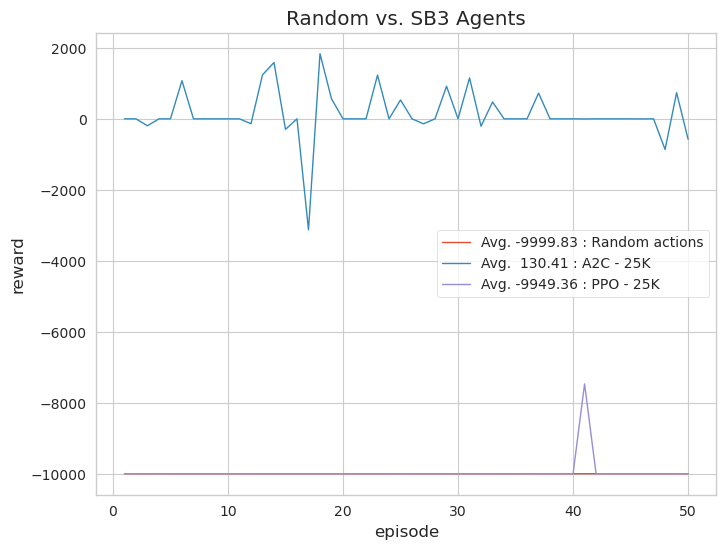

In [20]:
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))

for key in plot_data:
    if key == 'x':
        continue
    label = plot_settings[key]['label']
    line = plt.plot('x', key, data=data, linewidth=1, label=label)

plt.xlabel('episode')
plt.ylabel('reward')
plt.title('Random vs. SB3 Agents')
plt.legend()
plt.show()